In [1]:
push!(LOAD_PATH, "..")
using ASE
using PyPlot
using PyCall

In [2]:
at = bulk("Al")
at = repeat(at, (5, 5, 5))
X = get_positions(at)
nlist = ASENeighborList(at, 3.1)


ASE.ASENeighborList(PyObject <ase.calculators.neighborlist.NeighborList instance at 0x31aa47cf8>,[3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1  …  3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1])

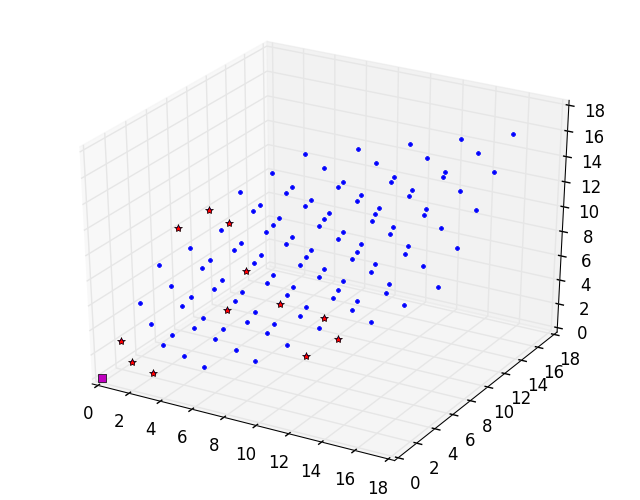

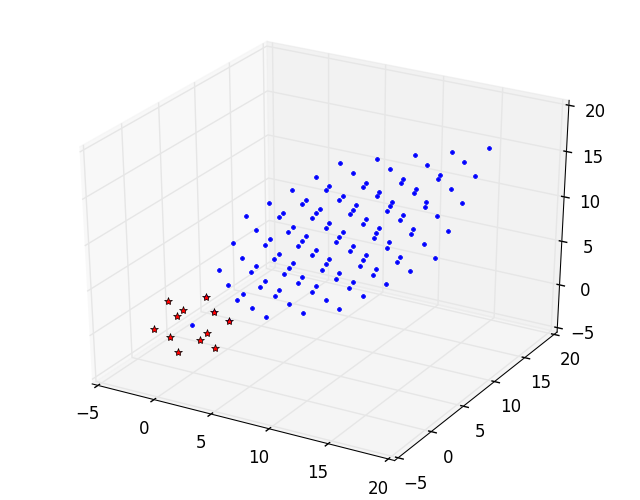

1-element Array{Any,1}:
 PyObject <mpl_toolkits.mplot3d.art3d.Line3D object at 0x31a937e90>

In [3]:

figure(1)
I, _ = get_neighbors(1, nlist)
plot3D(X[1,:][:], X[2,:][:], X[3,:][:], "b.")
plot3D(X[1,I][:], X[2,I][:], X[3,I][:], "r*")
plot3D([X[1,1];], [X[2,1];], [X[3,1];], "ms")

figure(2)
I, _, r = neighbors(1, nlist, at)
plot3D(X[1,:][:], X[2,:][:], X[3,:][:], "b.")
r .+= X[:,1]
plot3D(slice(r, 1,:), slice(r,2,:), slice(r,3,:), "r*")



 # Some Benchmarking

In [8]:
push!(LOAD_PATH, "..")
using ASE
using ProfileView

function loop_neigs(at, nlist)
    for n = 1:length(at)
        I, s, r = neighbors(n, nlist, at)
    end
end

function loop_neigs2(at, nlist)
    for (n, I, s, r) in (at, nlist)
        nothing
    end
end


at = bulk("Al")
at = repeat(at, (8, 8, 8))
nlist = ASENeighborList(at, 3.1)


@time loop_neigs(at, nlist)
@time loop_neigs(at, nlist)
@time loop_neigs2(at, nlist)
@time loop_neigs2(at, nlist)


  1.016549 seconds (224.66 k allocations: 11.485 MB, 1.36% gc time)
  0.889413 seconds (222.75 k allocations: 11.391 MB)
  0.488655 seconds (130.91 k allocations: 7.840 MB, 2.57% gc time)
  0.505179 seconds (126.69 k allocations: 7.648 MB)


In [16]:
using PyCall


In [92]:
# Standard call: 0.356330 seconds (89.00 k allocations: 3.258 MB)
@time for n = 1:500 I, off = nlist.po[:get_neighbors](0); end   
# get a tuple of PyArrays: 0.379282 seconds (62.00 k allocations: 2.022 MB)
@time for n = 1:500 ret = pycall(nlist.po[:get_neighbors], Tuple{PyArray, PyArray}, 0); end
# just get a PyObject: 0.039529 seconds (9.50 k allocations: 273.438 KB)
#    with lines 2-3 uncommented: 0.101147 seconds (28.50 k allocations: 820.313 KB)
@time for n = 1:500 begin 
        ret = pycall(nlist.po[:get_neighbors], PyObject, 0); end
        # ret1 = pycall(ret[:__getitem__], PyObject, 0)
        # ret2 = pycall(ret[:__getitem__], PyObject, 1)
end
nothing

  0.414566 seconds (89.00 k allocations: 3.258 MB)
  0.430945 seconds (62.00 k allocations: 2.022 MB, 4.86% gc time)
  0.101147 seconds (28.50 k allocations: 820.313 KB)


In [90]:
ret = pycall(nlist.po[:get_neighbors], PyObject, 0);
typeof(ret)

PyCall.PyObject

In [81]:
# pytypeof(ret1)


PyObject <type 'numpy.ndarray'>

LoadError: LoadError: KeyError: first not found
while loading In[70], in expression starting on line 1

In [1]:
push!(LOAD_PATH, "..")
using PyCall
using ASE
@pyimport matscipy.neighbours as matscipy_nlist
at = bulk("Al"; cubic=false)
at = repeat(at, (5, 5, 5))
println("length = ", length(at))
@time NL = matscipy_nlist.neighbour_list("ijd", at.po, 4.1)

length = 125
  

(Int32[0,0,0,0,0,0,0,0,0,0  …  124,124,124,124,124,124,124,124,124,124],Int32[29,45,49,9,105,109,4,34,21,101  …  24,78,104,3,90,95,115,120,15,75],[2.86378,2.86378,4.05,2.86378,2.86378,4.05,2.86378,4.05,2.86378,2.86378  …  2.86378,4.05,2.86378,4.05,4.05,2.86378,2.86378,2.86378,4.05,4.05])

0.525145 seconds (783.57 k allocations: 33.635 MB, 0.83% gc time)


In [ ]:
@time NL = matscipy_nlist.neighbour_list("ijd", at.po, 4.1)
@time NL = matscipy_nlist.neighbour_list("ijd", at.po, 4.1)
@time NL = matscipy_nlist.neighbour_list("ijd", at.po, 4.1)

@time NL = pycall(matscipy_nlist.neighbour_list, PyObject, "ijd", at.po, 4.1)
@time NL = pycall(matscipy_nlist.neighbour_list, PyObject, "ijd", at.po, 4.1)
@time NL = pycall(matscipy_nlist.neighbour_list, PyObject, "ijd", at.po, 4.1)
nothing

In [12]:
using Devectorize

function lj(r)
    t = 1.0 ./ r
    t = t .* t
    t = t .* t .* t
    sum(t.*t - 2.0*t)
end

function lj4(r)
    s = 0.0
    @simd for n = 1:length(r) @inbounds begin
            r[n] = 1.0 / (r[n]*r[n])
            r[n] = r[n]*r[n]*r[n]
            r[n] = (r[n]-2.0) * r[n]
            s = s + r[n]
        end
    end
    return s
end

function lj3(r)
    @devec r[:] = 1 ./ r[:]
    @devec r[:] = r[:] .* r[:]
    @devec r[:] = r[:] .* r[:] .* r[:]
    sum(r.*r - 2.0 * r)
end

function lj2(r)
    sum(r.^(-12) - 2.0*r.^(-6))
end

lj2 (generic function with 1 method)

In [15]:
at = repeat(bulk("Al"; cubic=true), (50,50,50))
@show length(at)

println("Neighbourlist")
@time (i,j,r) = matscipy_nlist.neighbour_list("ijd", at.po, 4.1)
# println("trying to be fast")
# @time lj(r)
println("basic julia")
@time L2 = lj2(r)
# println("devectorised")
# @time lj3(r)
println("SIMD")
@time L4 = lj4(r)
println("L2-L4 = ", L2-L4)

length(at) = 500000
Neighbourlist
  1.540141 seconds (256 allocations: 137.338 MB, 0.16% gc time)
basic julia
  0.662805 seconds (15 allocations: 274.659 MB, 21.29% gc time)
SIMD
  0.021393 seconds (5 allocations: 176 bytes)
L2-L4 = -1.7649508663453162e-6


In [3]:
push!(LOAD_PATH, "..")
using ASE
import MatSciPy
at = bulk("Al"; cubic=true)
at = repeat(at, (5, 5, 5))
# nlist = ASENeighborList(at, 3.1)
i, j, D, d = MatSciPy.neighbour_list(at, "ijDd", 3.1)



In [6]:
typeof("abc")

ASCIIString

i = Int32[1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,7,7,7,7,8,8,8,8,8,8,8,8,8,8,8,8,9,9,9,9,9,9,9,9,9,9,9,9,10,10,10,10,10,10,10,10,10,10,10,10,11,11,11,11,11,11,11,11,11,11,11,11,12,12,12,12,12,12,12,12,12,12,12,12,13,13,13,13,13,13,13,13,13,13,13,13,14,14,14,14,14,14,14,14,14,14,14,14,15,15,15,15,15,15,15,15,15,15,15,15,16,16,16,16,16,16,16,16,16,16,16,16,17,17,17,17,17,17,17,17,17,17,17,17,18,18,18,18,18,18,18,18,18,18,18,18,19,19,19,19,19,19,19,19,19,19,19,19,20,20,20,20,20,20,20,20,20,20,20,20,21,21,21,21,21,21,21,21,21,21,21,21,22,22,22,22,22,22,22,22,22,22,22,22,23,23,23,23,23,23,23,23,23,23,23,23,24,24,24,24,24,24,24,24,24,24,24,24,25,25,25,25,25,25,25,25,25,25,25,25,26,26,26,26,26,26,26,26,26,26,26,26,27,27,27,27,27,27,27,27,27,27,27,27,28,28,28,28,28,28,28,28,28,28,28,28,29,29,29,29,29,29,29,29,29,29,29,29,30,30,30,30,30,30,30,30,30,30,30,30,31,31,31,31,31,31,

6000-element Array{Int32,1}:
   1
   1
   1
   1
   1
   1
   1
   1
   1
   1
   1
   1
   2
   ⋮
 500
 500
 500
 500
 500
 500
 500
 500
 500
 500
 500
 500

In [1]:
push!(LOAD_PATH, "..")
using ASE
using PyPlot
using MatSciPy

at = bulk("Al", cubic=true)
at = repeat(at, (5, 5, 5))
X = get_positions(at)
nlist = ASENeighborList(at, 4.1)
I, _ = get_neighbors(1, nlist)
nlist2 = NeighbourList(4.1, at)
J = []
D = []
for (n, J, d, D) in Sites(nlist2)
    break
end



(size(state.neiglist.Q['X']),state.n) = ((3,500),0)

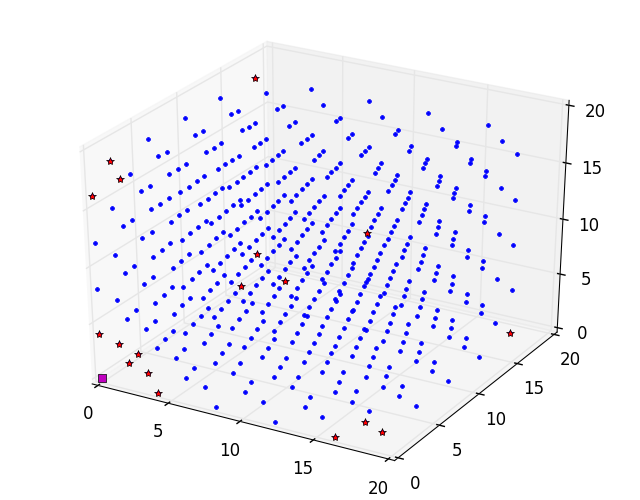

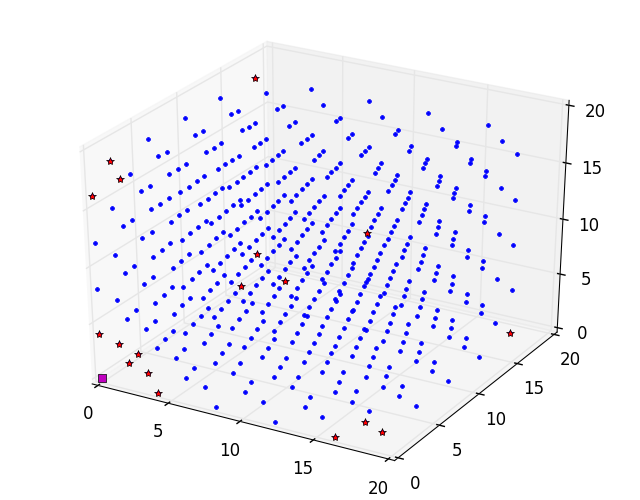

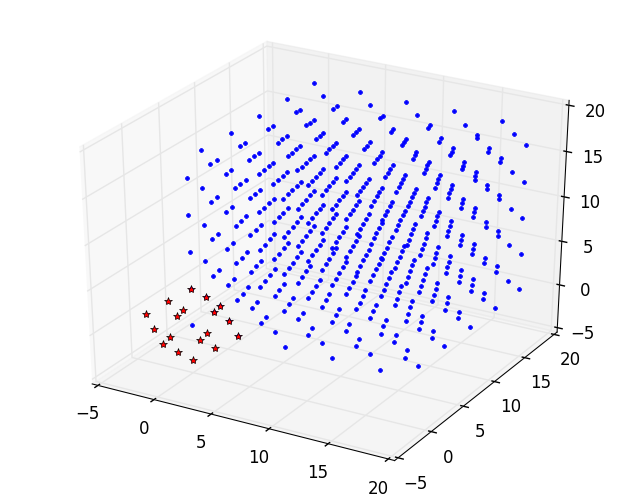

1-element Array{Any,1}:
 PyObject <mpl_toolkits.mplot3d.art3d.Line3D object at 0x31b868790>

In [10]:
figure(1)
plot3D(X[1,:][:], X[2,:][:], X[3,:][:], "b.")
plot3D(X[1,I][:], X[2,I][:], X[3,I][:], "r*")
plot3D([X[1,1];], [X[2,1];], [X[3,1];], "ms")

figure(2)
plot3D(X[1,:][:], X[2,:][:], X[3,:][:], "b.")
plot3D(X[1,J][:], X[2,J][:], X[3,J][:], "r*")
plot3D([X[1,1];], [X[2,1];], [X[3,1];], "ms")

figure(3)
plot3D(X[1,:][:], X[2,:][:], X[3,:][:], "b.")
D .+= X[:,1]
plot3D(D[1,:][:], D[2,:][:], D[3,:][:], "r*")




(size(state.neiglist.Q['X']),state.n) = ((3,500),0)
1
(size(state.neiglist.Q['X']),state.n) = ((3,500),1)

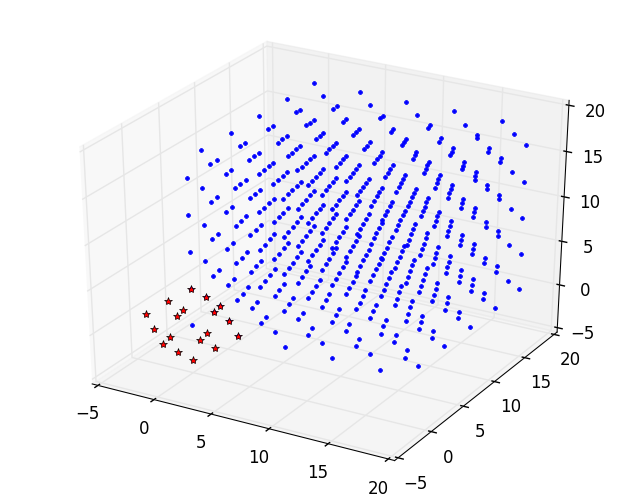

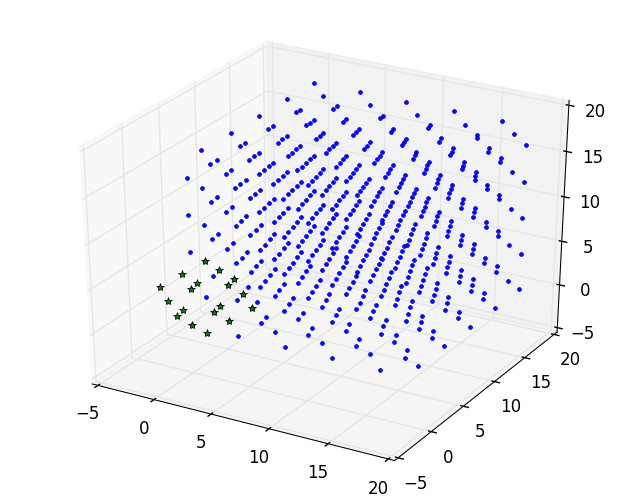

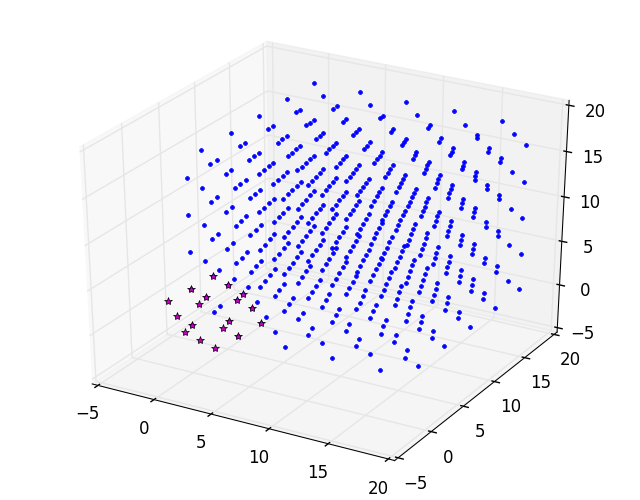

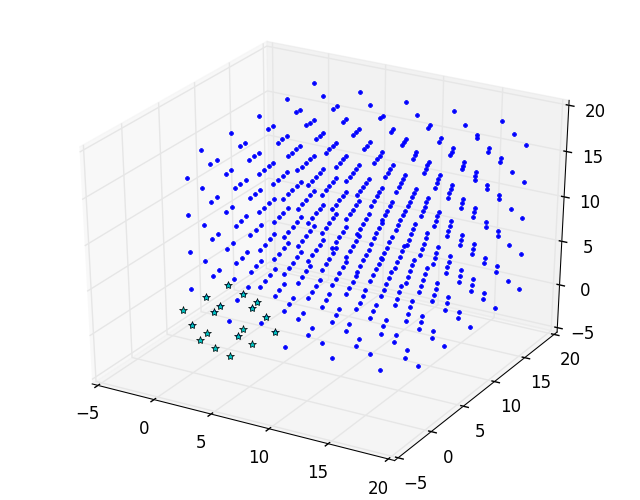

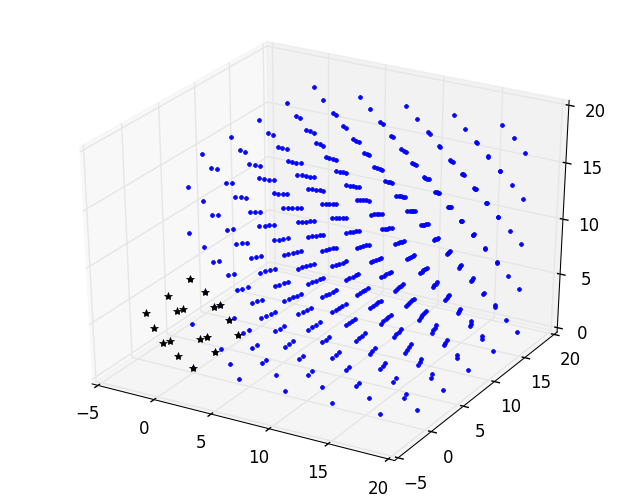


2
(size(state.neiglist.Q['X']),state.n) = ((3,500),2)
3
(size(state.neiglist.Q['X']),state.n) = ((3,500),3)
4
(size(state.neiglist.Q['X']),state.n) = ((3,500),4)
5


In [2]:
for (n, J, d, D) in Sites(nlist2)
    figure(n)
    plot3D(X[1,:][:], X[2,:][:], X[3,:][:], "b.")
    D .+= X[:,n]
    plot3D(D[1,:][:], D[2,:][:], D[3,:][:], "r*")
    
    if n > 4
        break
    end
end


In [5]:
size(nlist2.Q['X'])

(0,)

In [6]:
update!(nlist2, at)

LoadError: LoadError: UndefVarError: X not defined
while loading In[6], in expression starting on line 1